In [1]:
from google.colab import drive
import os

drive.mount('/content/GoogleDrive', force_remount=True)
path = '/content/GoogleDrive/My Drive/ABSA'
os.chdir(path)
!ls

Mounted at /content/GoogleDrive
data		     model_absa.ipynb	  preprocess.py  VnCoreNLP-1.1.1.jar
hs_err_pid60807.log  model_absa_v1.ipynb  vi-vocab	 VnCoreNLP-1.2.jar
model		     model_absa_v2.ipynb  VnCoreNLP	 wordsegmenter.rdr.txt


## Import Libs

In [2]:
!pip install -q transformers
!pip install -q tf-models-official
!pip install py_vncorenlp vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import re
from gensim.utils import simple_preprocess
import pandas as pd
from nltk import flatten
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from tensorflow.train import CheckpointOptions, latest_checkpoint
from tensorflow.data import Dataset
from transformers import TFAutoModel
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.utils import plot_model
import pickle 

## Connect TPU

In [4]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # tìm thông tin TPU
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Load Data

In [5]:
with open('./data/VLSP2018-SA-Restaurant-train.txt','r', encoding="utf8") as file:
    train = file.readlines()
with open('./data/VLSP2018-SA-Restaurant-dev.txt','r', encoding="utf8") as file:
    val = file.readlines()
with open('./data/VLSP2018-SA-Restaurant-test.txt','r', encoding="utf8") as file:
    test = file.readlines()

In [6]:
train[:10]

['\ufeff#1\n',
 '_ Ảnh chụp từ hôm qua, đi chơi với gia đình và 1 nhà họ hàng đang sống tại Sài Gòn. _ Hôm qua đi ăn trưa muộn, ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền, bởi vậy mới quên chụp các phần gọi thêm với nước mắm, chỉ chụp món chính thôi! _ Đói quá nên không biết đánh giá đồ ăn kiểu gì luôn 😅😅😅_ Chọn cái này vì thấy nó lạ với tui.\n',
 '{FOOD#STYLE&OPTIONS, neutral}, {FOOD#QUALITY, neutral}\n',
 '\n',
 '#2\n',
 '_Hương vị thơm ngon, ăn cay cay rất thích, nêm nếm vừa miệng. Ngoài ra menu quán cũng nhiều món khác nhau tha hồ cho bạn lựa chọn luôn._Quán rộng rãi, view khá đẹp và cũng thoáng lắm. Khách của quán đông nên nhiều khi nhân viên phục vụ không được nhanh cho lắm._Thịt heo rừng giá theo kì nên nhớ hỏi trước nhưng trung bình là 150k 1 phần. Hai bạn đi chung chi khoảng 400k hơn là ổn nhé.\n',
 '{FOOD#QUALITY, positive}, {FOOD#STYLE&OPTIONS, positive}, {AMBIENCE#GENERAL, positive}, {RESTAURANT#GENERAL, positive}, {SERVICE#GENERAL, negative}, {FOOD#PRICES, neutral

### Xử lý dữ liệu

In [7]:
def get_data(data):
    get = 1
    review = []
    label = []
    for text in data:
        if get == 2:
            review.append(text)
            get+=1
        elif get == 3:
            label.append(text)
            get+=1
        elif get == 4:
            get=1
        else: get+=1
    return review,label

In [8]:
train_review, train_label = get_data(train)
val_review, val_label = get_data(val)
test_review, test_label = get_data(test)

In [9]:
train_review[:5]

['_ Ảnh chụp từ hôm qua, đi chơi với gia đình và 1 nhà họ hàng đang sống tại Sài Gòn. _ Hôm qua đi ăn trưa muộn, ai cũng đói hết nên lúc có đồ ăn là nhào vô ăn liền, bởi vậy mới quên chụp các phần gọi thêm với nước mắm, chỉ chụp món chính thôi! _ Đói quá nên không biết đánh giá đồ ăn kiểu gì luôn 😅😅😅_ Chọn cái này vì thấy nó lạ với tui.\n',
 '_Hương vị thơm ngon, ăn cay cay rất thích, nêm nếm vừa miệng. Ngoài ra menu quán cũng nhiều món khác nhau tha hồ cho bạn lựa chọn luôn._Quán rộng rãi, view khá đẹp và cũng thoáng lắm. Khách của quán đông nên nhiều khi nhân viên phục vụ không được nhanh cho lắm._Thịt heo rừng giá theo kì nên nhớ hỏi trước nhưng trung bình là 150k 1 phần. Hai bạn đi chung chi khoảng 400k hơn là ổn nhé.\n',
 '- 1 bàn tiệc hoành tráng 3 đứa ăn no muốn tắt thở mà giá chỉ 228k (ăn trung đợt giảm 10%), mình thích nhất pad thái vs gà nướng - đúng kiểu Thái luôn, quán nhỏ, trong hẻm, cơ mà anh phục vụ rất dễ thương, chế biến hợp vệ sinh, bếp lộ thiên lại còn có thể xin nấu

In [10]:
train_label[:5]

['{FOOD#STYLE&OPTIONS, neutral}, {FOOD#QUALITY, neutral}\n',
 '{FOOD#QUALITY, positive}, {FOOD#STYLE&OPTIONS, positive}, {AMBIENCE#GENERAL, positive}, {RESTAURANT#GENERAL, positive}, {SERVICE#GENERAL, negative}, {FOOD#PRICES, neutral}, {RESTAURANT#PRICES, neutral}\n',
 '{FOOD#STYLE&OPTIONS, positive}, {FOOD#PRICES, positive}, {FOOD#QUALITY, positive}, {AMBIENCE#GENERAL, negative}, {LOCATION#GENERAL, negative}, {SERVICE#GENERAL, positive}, {RESTAURANT#MISCELLANEOUS, positive}, {RESTAURANT#GENERAL, positive}\n',
 '{FOOD#STYLE&OPTIONS, positive}, {RESTAURANT#GENERAL, positive}, {FOOD#QUALITY, positive}\n',
 '{FOOD#STYLE&OPTIONS, positive}, {FOOD#QUALITY, positive}\n']

In [11]:
Aspect = ['AMBIENCE#GENERAL',	'DRINKS#PRICES',	'DRINKS#QUALITY',	'DRINKS#STYLE&OPTIONS',	'FOOD#PRICES',	'FOOD#QUALITY',	'FOOD#STYLE&OPTIONS',
          	'LOCATION#GENERAL',	'RESTAURANT#GENERAL',	'RESTAURANT#MISCELLANEOUS',	'RESTAURANT#PRICES',	'SERVICE#GENERAL']
pos = [1,0,0]
neg = [0,1,0]
neu = [0,0,1]
none = [0,0,0]
sentiments = ['positive','negative','neutral']
sentiments = ['positive','negative','neutral']

In [12]:
def get_sentiment_label(data_label):
    sentiment_label = []
    for i in data_label:
        sentiment_text = []
        for j in Aspect:
            if j in i:
                if sentiments[0] in i:
                    sentiment_text.append(1)
                elif sentiments[1] in i:
                    sentiment_text.append(2)
                elif sentiments[2] in i:
                    sentiment_text.append(3)
            else:
                sentiment_text.append(0)
        sentiment_label.append(sentiment_text)
    return sentiment_label

In [13]:
sentiment_label_train = get_sentiment_label(train_label)
sentiment_label_val = get_sentiment_label(val_label)
sentiment_label_test = get_sentiment_label(test_label)

In [14]:
df_train = pd.DataFrame(sentiment_label_train, columns = Aspect)
df_val = pd.DataFrame(sentiment_label_val, columns = Aspect)
df_test = pd.DataFrame(sentiment_label_test, columns = Aspect)
df_train

,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE&OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE&OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,0,0,0,0,0,3,3,0,0,0,0,0
1,1,0,0,0,1,1,1,0,1,0,1,1
2,1,0,0,0,1,1,1,1,1,1,0,1
3,0,0,0,0,0,1,1,0,1,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2956,0,0,0,0,0,1,0,0,0,0,0,0
2957,0,0,0,0,1,1,1,1,0,0,0,0
2958,0,0,0,0,0,0,0,0,1,1,0,0
2959,1,0,0,0,0,0,0,0,1,0,1,0


In [74]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(0, len(df.columns)):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [75]:
y_train = make_outputs(df_train)
y_val = make_outputs(df_val)
y_test = make_outputs(df_test)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[0]

Train outputs: (2961, 12, 4)
Validate outputs: (1290, 12, 4)
Test outputs: (500, 12, 4)


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [23]:
from vncorenlp import VnCoreNLP
tokenizer = VnCoreNLP(' VnCoreNLP/VnCoreNLP-1.1.1.jar', annotators= 'wseg', max_heap_size = '-Xmx500m')

In [24]:
text = "Đây là một câu tiếng Việt."
# Tách từ trong câu
tokens = tokenizer.tokenize(text)
# Hiển thị kết quả
print(tokens)

[['Đây', 'là', 'một', 'câu', 'tiếng', 'Việt', '.']]


In [25]:
VN_CHARS_LOWER = u'ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđð'
VN_CHARS_UPPER = u'ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸÐĐ'
VN_CHARS = VN_CHARS_LOWER + VN_CHARS_UPPER
def no_marks(s):
    __INTAB = [ch for ch in VN_CHARS]
    __OUTTAB = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"*2
    __OUTTAB += "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"*2
    __r = re.compile("|".join(__INTAB))
    __replaces_dict = dict(zip(__INTAB, __OUTTAB))
    result = __r.sub(lambda m: __replaces_dict[m.group(0)], s)
    return result

In [26]:
replace_list = pickle.load(open(f'{path}/data/replace.pkl','rb'))
pickle.dump(replace_list,open(f'{path}/data/replace.pkl','wb'))

In [27]:
def text_preprocess(text):
    check = re.search(r'([a-z])\1+',text)
    if check:
          if len(check.group())>2:
            text = re.sub(r'([a-z])\1+', lambda m: m.group(1), text, flags=re.IGNORECASE) #remove các ký tự kéo dài như hayyy, ngonnnn...

          text = text.strip() #loại dấu cách đầu câu
        
          for k, v in replace_list.items():       #replace các từ có trong replace_list
            text = text.replace(k, v)       
          text = re.sub('[!”"#$%&’()•/:;<=>-?@[\]^`{|}~+*_-]', ' ', text) #special character
          text = re.sub('\d+k', '', text) #300k, 200k 
          text = re.sub('\d+', '', text) #number
          text = re.sub('(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ', text) #web address
          text = re.sub('www\.\S+\.com', ' ', text) #web address
          text = re.sub('@\S+', ' ', text) #user mention
          text = re.sub('[0-9]k', ' ', text)
          emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
          text = re.sub(emoji_pattern, '', text)
          
          text = ' '.join(i for i in flatten(tokenizer.tokenize(text)))
          text = text.lower() 
    return text


In [28]:
def preprocess(data):
    token = []
    token_nomarks = []
    for text in data:
        check = re.search(r'([a-z])\1+',text)
        if check:
          if len(check.group())>2:
            text = re.sub(r'([a-z])\1+', lambda m: m.group(1), text, flags=re.IGNORECASE) #remove các ký tự kéo dài như hayyy, ngonnnn...

        text = text.strip() #loại dấu cách đầu câu
      
        for k, v in replace_list.items():       #replace các từ có trong replace_list
          text = text.replace(k, v)       
        text = re.sub('[!”"#$%&’()•/:;<=>-?@[\]^`{|}~+*_-]', ' ', text) #special character
        text = re.sub('\d+k', '', text) #300k, 200k 
        text = re.sub('\d+', '', text) #number
        text = re.sub('(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ', text) #web address
        text = re.sub('www\.\S+\.com', ' ', text) #web address
        text = re.sub('@\S+', ' ', text) #user mention
        text = re.sub('[0-9]k', ' ', text)
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = re.sub(emoji_pattern, '', text)
        
        text = ' '.join(i for i in flatten(tokenizer.tokenize(text)))
        text = text.lower()             
        text_nomarks = token_nomarks.append(no_marks(text))
        token.append(text)
    return token, token_nomarks

In [29]:
train_review, train_review1  = preprocess(train_review)
train_review += train_review1
val_review, val_review1 = preprocess(val_review)
val_review += val_review1
test_review, test_review1 = preprocess(test_review)
test_review += test_review1



In [30]:
train_review[:3]

['ảnh chụp từ hôm_qua , đi chơi với gia_đình và nhà họ_hàng đang sống tại sài_gòn . hôm_qua đi ăn trưa muộn , ai cũng đói hết nên lúc có đồ_ăn là nhào vô ăn_liền , bởi_vậy mới quên chụp các phần gọi thêm với nước_mắm , chỉ chụp món chính thôi đói quá nên không biết đánh_giá đồ_ăn kiểu gì luôn chọn cái này vì thấy nó lạ với tui .',
 'hương_vị thơm ngon , ăn cay cay rất thích , nêm nếm vừa_miệng . ngoài_ra menu quán cũng nhiều món khác nhau tha_hồ cho bạn lựa_chọn luôn . quán rộng_rãi , view khá đẹp và cũng thoáng lắm . khách của quán đông nên nhiều khi nhân_viên phục_vụ không được nhanh cho lắm . thịt heo rừng giá theo kì nên nhớ hỏi trước nhưng trung_bình là phần . hai bạn đi chung chi khoảng hơn là ổn nhé .',
 'bàn tiệc hoành_tráng đứa ăn no muốn tắt_thở mà giá chỉ ăn trung đợt giảm , mình thích nhất pad thái với gà nướng đúng kiểu thái luôn , quán nhỏ , trong hẻm , cơ_mà anh phục_vụ rất dễ_thương , chế_biến hợp vệ_sinh , bếp lộ_thiên lại còn có_thể xin nấu cùng đã']

In [31]:
len(train_review)

5922

In [76]:
y_train = np.concatenate((y_train, y_train), axis=0)
y_val = np.concatenate((y_val, y_val), axis=0)
y_test = np.concatenate((y_test, y_test), axis=0)

In [108]:
y_train[:3]

array([[[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0]],

       [[0, 1, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0]]], dtype=uint8)

In [78]:
len(y_train)

5922

In [35]:
PRETRAINED_MODEL = 'vinai/phobert-base' #@param ['vinai/phobert-base', 'vinai/phobert-large', 'bert-base-multilingual-uncased','bert-base-multilingual-cased ', 'distilbert-base-multilingual-cased'] {allow-input: true}
     

In [36]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [38]:
def tokenize_function(dataset):
    return tokenizer(dataset['review'], max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

In [81]:
tokenized_train = tokenizer(train_review, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)
tokenized_dev = tokenizer(val_review, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)
tokenized_test = tokenizer(test_review, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)
print('input_ids of sentence 1484:', tokenized_train['input_ids'][1484])

input_ids of sentence 1484: [0, 4650, 2198, 1476, 33626, 6262, 6, 7873, 1111, 33626, 6262, 5, 1329, 36, 14972, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [40]:
tokenizer.model_max_length

256

In [ ]:
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
MODEL_PATH = '/content/GoogleDrive/My Drive/ABSA/model'
BATCH_SIZE = 512

STEPS_PER_EPOCH = len(train_review) // BATCH_SIZE
VALIDATION_STEPS = len(val_review) // BATCH_SIZE
EPOCHS = 15

In [83]:
def preprocess_tokenized_dataset(tokenized_dataset, tokenizer, labels, batch_size, shuffle=False):
    features = {x: tokenized_dataset[x] for x in tokenizer.model_input_names}
    labels = labels.reshape(len(labels), -1)

    tf_dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    if shuffle:
        tf_dataset = tf_dataset.shuffle(buffer_size=len(tf_dataset))
    return tf_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [84]:
train_tf_dataset = preprocess_tokenized_dataset(tokenized_train, tokenizer, y_train, BATCH_SIZE, shuffle=True)
val_tf_dataset = preprocess_tokenized_dataset(tokenized_dev, tokenizer, y_val, BATCH_SIZE)
test_tf_dataset = preprocess_tokenized_dataset(tokenized_test,  tokenizer, y_test, BATCH_SIZE)
train_tf_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 48), dtype=tf.uint8, name=None))>

In [79]:
def create_model(optimizer):
    inputs = {
        'input_ids'     : Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_ids'), 
        'token_type_ids': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='token_type_ids'), 
        'attention_mask': Input((MAX_SEQUENCE_LENGTH,), dtype='int32', name='attention_mask'),
    }
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)
    hidden_states = pretrained_bert(inputs).hidden_states

    pooled_output = concatenate(
        tuple([hidden_states[i] for i in range(-4, 0)]), 
        name = 'last_4_hidden_states',
        axis = -1
    )[:, 0, :]
    x = Dropout(0.2)(pooled_output)
    print(pooled_output)

    outputs = concatenate([
        Dense(
            units = 4, 
            activation = 'softmax',
            name = label.replace('#', '-').replace('&', '_'),
        )(x) for label in df_train.columns
    ], axis = -1)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

In [45]:
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [85]:
num_train_steps = STEPS_PER_EPOCH * EPOCHS
optimizer = optimization.create_optimizer(
    init_lr = 2e-4, 
    num_train_steps = num_train_steps, 
    num_warmup_steps = num_train_steps // 10
)
type(optimizer)

official.modeling.optimization.legacy_adamw.AdamWeightDecay

## Callbacks

In [47]:
# callback = tf.keras.callbacks.ModelCheckpoint('./model/modelBert.h5', monitor = 'val_loss')

In [86]:
# Stop if no improvement after 5 epochs
callback = EarlyStopping(monitor='val_loss', patience = 5, verbose = 1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Prevent from UnimplementedError when using TPU
options = CheckpointOptions(experimental_io_device='/job:localhost')

# Create a callback that saves the model's weights every 10 epochs
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path, 
    save_best_only = True,
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH, 
    options = options,  
    verbose = 1
)
     

## Training

In [87]:
with strategy.scope(): # For using TPU
    model = create_model(optimizer)
    history = model.fit(
        train_tf_dataset, 
        validation_data = val_tf_dataset, 
        validation_steps = VALIDATION_STEPS,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [
            # schedule_lr_callback, # When not use AdamW
            # reduce_lr_callback, # When not use AdamW 
            callback, 
            checkpoint_callback
        ],
        verbose = 1,
    )
    

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem_3/strided_slice:0', description="created by layer 'tf.__operators__.getitem_3'")
Epoch 1/15


282/282 [==============================] - 132s 167ms/step - loss: 0.2361 - val_loss: 0.1677
Epoch 2/15
282/282 [==============================] - 32s 115ms/step - loss: 0.1610 - val_loss: 0.1514
Epoch 3/15
282/282 [==============================] - 33s 115ms/step - loss: 0.1324 - val_loss: 0.1656
Epoch 4/15
282/282 [==============================] - 33s 116ms/step - loss: 0.1113 - val_loss: 0.1644
Epoch 5/15
282/282 [==============================] - 32s 114ms/step - loss: 0.0916 - val_loss: 0.2021
Epoch 6/15
282/282 [==============================] - 33s 116ms/step - loss: 0.0751 - val_loss: 0.1804
Epoch 7/15
282/282 [==============================] - 33s 116ms/step - loss: 0.0600 - val_loss: 0.2129
Epoch 7: early stopping


In [88]:
model.save(f'{MODEL_PATH}/bert.h5')

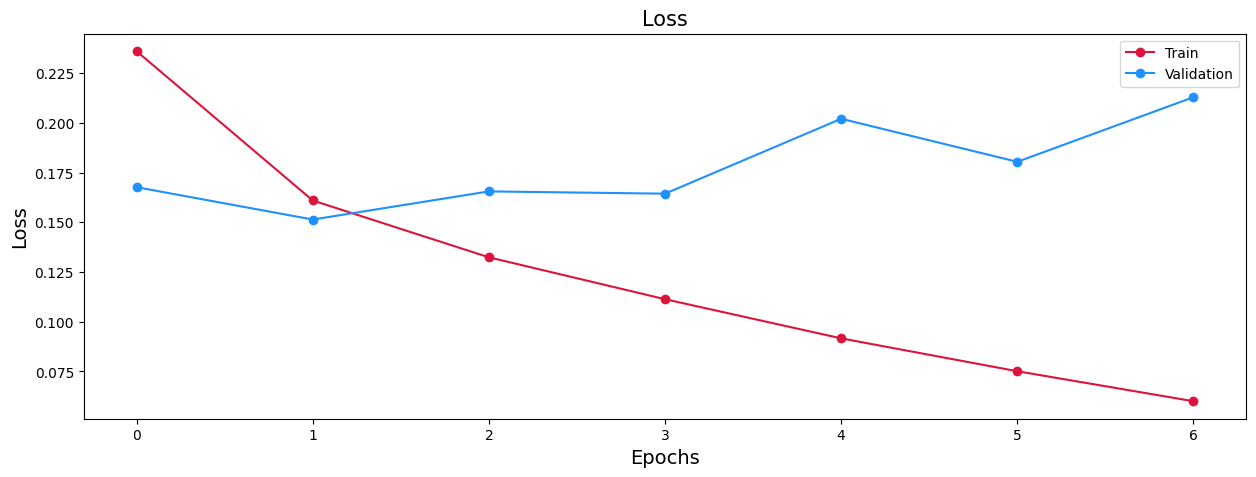

In [89]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 5))
plt.plot(history.history['loss'], linestyle='solid', marker='o', color='crimson', label='Train')
plt.plot(history.history['val_loss'], linestyle='solid', marker='o', color='dodgerblue', label='Validation')
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.title('Loss', fontsize = 15)
plt.legend(loc='best')
fig.savefig(f'{MODEL_PATH}/evaluation.png', bbox_inches='tight') 
plt.show()

In [90]:
with strategy.scope():
    reloaded_model = create_model(optimizer)
    # reloaded_model.load_weights(latest_checkpoint(checkpoint_dir))
    reloaded_model.load_weights(f'{MODEL_PATH}/bert.h5')
    reloaded_model.summary()

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


KerasTensor(type_spec=TensorSpec(shape=(None, 3072), dtype=tf.float32, name=None), name='tf.__operators__.getitem_4/strided_slice:0', description="created by layer 'tf.__operators__.getitem_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                               

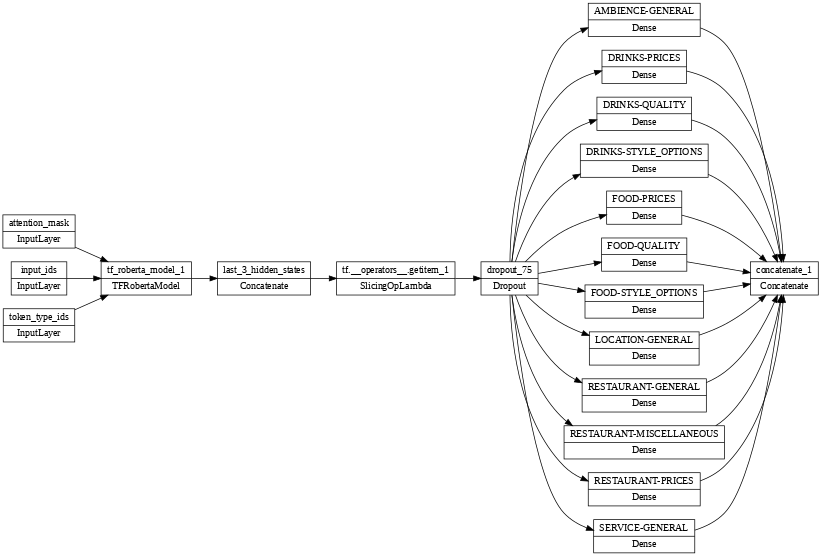

In [53]:
plot_model(reloaded_model, to_file=f'{MODEL_PATH}/architecture.png', rankdir='LR', dpi=52)

## Prediction

In [91]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax[:1]

array([[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]])

## Predict on test data

In [92]:
def predict(model, inputs, batch_size = 1, verbose = 0):
    y_pred = model.predict(inputs, batch_size = batch_size, verbose = verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1) # sentiment values (position that have max value)
    

In [93]:
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments): 
        if sentiment: print(f'=> {category},{sentiment}')

In [94]:
y_pred = predict(reloaded_model, test_tf_dataset, BATCH_SIZE, verbose=1)
reloaded_model.evaluate(test_tf_dataset, batch_size = BATCH_SIZE, verbose=1)

48/48 [==============================] - 20s 138ms/step - loss: 0.3220


0.32200726866722107

In [95]:
y_pred[:1]

array([[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]])

In [96]:
replacements = {0: None, 1: 'positive', 2: 'negative', 3: 'neutral'}
categories = df_test.columns
print('Example:', test_review[0])
print_acsa_pred(replacements, categories, y_pred[0])

Example: đây là trong những quán mà mình thích vì vị trà đậm và thơm cũng như mùi_vị đặc_trưng hơn hẳn những quán khác nè trà sữa trân_châu sợi trà sữa pha khá ngon , vị trà chát và mùi hương khá rõ , không quá ngọt , rất đúng với gu mình trà đào vị trà đào ở đây cũng đặc_biệt hơn hẳn những quán khác , không phải chua_ngọt như thưởng thấy mà có mùi trà rất ngon cà_phê đá xay món đá xay ở đây uống cũng ngon không kém trà_nè , mùi_vị thơm hương cà_phê , vị đắng kết_hợp hoàn_hảo với độ béo ngọt của whipping cream , không quá đắng , cũng không quá ngọt hay lạt_lẽo mà dịu nhẹ , thơm và dễ uống lắm trà vải thiết quan âm trà vải có mùi_vị rất thơm ngon mùi vải mà vẫn nghe rõ vị trà , có chút vị chát nhẹ mùi trà thơm rất thích , không phải chỉ toàn vị syrup vải ngọt gắt như nhiều chỗ khác . do trà ở đây pha khá đậm nên bạn nào uống mà đang đói sẽ dễ say nha , hoặc ban_đêm có_thể khó ngủ à , cảnh_báo trước trà thiết quan âm latte ly này thì vị trà rất đậm nên cảm_giác hơi nhạt và chát , phần ke

## Predict random text

In [97]:
input_text = "quán đẹp, đồ ăn ngon nhưng nhân viên phục vụ thái độ tế"

In [98]:
example_input = text_preprocess(input_text)
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}

pred = predict(reloaded_model, Dataset.from_tensor_slices(features))
print_acsa_pred(replacements, categories, pred[0])

=> FOOD#QUALITY,positive
=> SERVICE#GENERAL,positive


## Report metrics

### Aspect Detection

In [99]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        if index < len(categories):
            aspect_test.append(bool(col_test) * categories[index])
            aspect_pred.append(bool(col_pred) * categories[index])

In [100]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

                          precision    recall  f1-score   support

                             0.8392    0.8519    0.8455      7162
        AMBIENCE#GENERAL     0.8839    0.8059    0.8431       510
           DRINKS#PRICES     0.6197    0.2895    0.3946       152
          DRINKS#QUALITY     0.8462    0.3099    0.4536       142
    DRINKS#STYLE&OPTIONS     0.7097    0.2391    0.3577        92
             FOOD#PRICES     0.8055    0.7130    0.7564       662
            FOOD#QUALITY     0.9400    0.9606    0.9502       914
      FOOD#STYLE&OPTIONS     0.9059    0.8958    0.9008       806
        LOCATION#GENERAL     0.8072    0.8184    0.8128       358
      RESTAURANT#GENERAL     0.5215    0.8969    0.6595       446
RESTAURANT#MISCELLANEOUS     0.8548    0.2038    0.3292       260
       RESTAURANT#PRICES     0.2692    0.4315    0.3316       146
         SERVICE#GENERAL     0.7255    0.7629    0.7437       350

                accuracy                         0.8142     12000
        

In [101]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred.flatten()
target_names = list(map(str, replacements.values()))
     

In [103]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits = 4))

              precision    recall  f1-score   support

        None     0.8392    0.8519    0.8455      7162
    positive     0.7539    0.7570    0.7554      4662
    negative     0.4500    0.1184    0.1875       152
     neutral     0.4444    0.1667    0.2424        24

    accuracy                         0.8043     12000
   macro avg     0.6219    0.4735    0.5077     12000
weighted avg     0.8003    0.8043    0.8010     12000



In [104]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
      if index < len(categories):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')
     

In [105]:

aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                                   precision    recall  f1-score   support

            AMBIENCE#GENERAL,None     0.8150    0.8898    0.8507       490
        AMBIENCE#GENERAL,negative     0.0000    0.0000    0.0000        10
        AMBIENCE#GENERAL,positive     0.8769    0.8120    0.8432       500
               DRINKS#PRICES,None     0.8837    0.9682    0.9240       848
           DRINKS#PRICES,negative     1.0000    0.0000    0.0000         4
           DRINKS#PRICES,positive     0.6056    0.2905    0.3927       148
              DRINKS#QUALITY,None     0.8966    0.9907    0.9413       858
          DRINKS#QUALITY,negative     1.0000    0.0000    0.0000         6
          DRINKS#QUALITY,positive     0.8077    0.3088    0.4468       136
        DRINKS#STYLE&OPTIONS,None     0.9278    0.9901    0.9579       908
    DRINKS#STYLE&OPTIONS,negative     1.0000    0.0000    0.0000         4
    DRINKS#STYLE&OPTIONS,positive     0.6774    0.2386    0.3529        88
                 FOOD#PR

In [106]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [107]:

df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)

,precision,recall,f1-score,accuracy
Aspect Detection,0.748332,0.629161,0.644518,0.814167
Polarity Detection,0.621886,0.473479,0.507710,0.804333
Aspect + Polarity,0.707536,0.458837,0.473062,0.804333
